In [8]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

import lightgbm as lgb
import matplotlib.pyplot as plt

In [9]:
SEED = 42
np.random.seed(SEED)

DATA_PATH = Path(r"F:\Workspace\Working\college-minor-project\datasets\diabetes.csv")

In [10]:
df = pd.read_csv(DATA_PATH)
print(df.head())
print("\nShape:", df.shape)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
0            6      148             72             35        0 33.6000   
1            1       85             66             29        0 26.6000   
2            8      183             64              0        0 23.3000   
3            1       89             66             23       94 28.1000   
4            0      137             40             35      168 43.1000   

   DiabetesPedigreeFunction  Age  Outcome  
0                    0.6270   50        1  
1                    0.3510   31        0  
2                    0.6720   32        1  
3                    0.1670   21        0  
4                    2.2880   33        1  

Shape: (768, 9)


In [11]:
cols_zero_as_missing = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]

df[cols_zero_as_missing] = df[cols_zero_as_missing].replace(0, np.nan)

print(df.isna().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [12]:
FEATURE_COLS = [c for c in df.columns if c != "Outcome"]
TARGET_COL = "Outcome"

X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=SEED,
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (614, 8) Test shape: (154, 8)


In [28]:
LGB_PARAMS = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,        # lower lr
    "num_leaves": 31,             # maybe 31–63
    "max_depth": -1,
    "min_child_samples": 10,      # a bit smaller
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.0,
    "reg_lambda": 0.1,
    "n_estimators": 2000,         # rely on early stopping
    "random_state": 42,
    "n_jobs": -1,
    "class_weight": "balanced",   # you can experiment with this
}


In [29]:
def train_and_eval_lightgbm(X_tr, y_tr, X_va, y_va, params, early_stopping_rounds=100):
    model = lgb.LGBMClassifier(**params)

    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(early_stopping_rounds),
            lgb.log_evaluation(period=0)  # silent training
        ]
    )

    # Predict probabilities and labels
    y_proba = model.predict_proba(X_va)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_va, y_pred)
    prec = precision_score(y_va, y_pred, zero_division=0)
    rec = recall_score(y_va, y_pred, zero_division=0)
    f1 = f1_score(y_va, y_pred, zero_division=0)
    roc = roc_auc_score(y_va, y_proba)

    return model, {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
    }


In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

fold_metrics = []
models = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, y_tr = X_train.iloc[tr_idx], y_train[tr_idx]
    X_va, y_va = X_train.iloc[va_idx], y_train[va_idx]

    model, metrics = train_and_eval_lightgbm(X_tr, y_tr, X_va, y_va, LGB_PARAMS)
    models.append(model)
    fold_metrics.append(metrics)

    print(
        f"Fold {fold}: "
        f"Acc={metrics['accuracy']:.3f}, "
        f"Prec={metrics['precision']:.3f}, "
        f"Rec={metrics['recall']:.3f}, "
        f"F1={metrics['f1']:.3f}, "
        f"ROC-AUC={metrics['roc_auc']:.3f}"
    )


[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [31]:
cv_df = pd.DataFrame(fold_metrics, index=[f"fold_{i}" for i in range(1, 6)])
cv_df.loc["mean"] = cv_df.mean()
cv_df.loc["std"] = cv_df.std()

print("\n===== 5-fold CV results (LightGBM, train set) =====")
print(cv_df.round(3))


===== 5-fold CV results (LightGBM, train set) =====
        accuracy  precision  recall     f1  roc_auc
fold_1    0.7970     0.7250  0.6740 0.6990   0.8610
fold_2    0.7890     0.6730  0.7670 0.7170   0.8190
fold_3    0.7720     0.6830  0.6510 0.6670   0.8620
fold_4    0.7480     0.6150  0.7440 0.6740   0.7980
fold_5    0.7620     0.6440  0.6900 0.6670   0.8370
mean      0.7740     0.6680  0.7060 0.6850   0.8350
std       0.0180     0.0370  0.0440 0.0200   0.0250


In [32]:
final_model = lgb.LGBMClassifier(**LGB_PARAMS)

final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(100),
        lgb.log_evaluation(period=50)
    ]
)

y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_roc = roc_auc_score(y_test, y_test_proba)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [33]:
print("\n===== Test results (LightGBM) =====")
print(classification_report(y_test, y_test_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
print(
    f"Accuracy: {test_acc:.4f}, "
    f"F1: {test_f1:.4f}, "
    f"Precision: {test_prec:.4f}, "
    f"Recall: {test_rec:.4f}, "
    f"ROC-AUC: {test_roc:.4f}"
)


===== Test results (LightGBM) =====
              precision    recall  f1-score   support

           0     0.8977    0.7900    0.8404       100
           1     0.6818    0.8333    0.7500        54

    accuracy                         0.8052       154
   macro avg     0.7898    0.8117    0.7952       154
weighted avg     0.8220    0.8052    0.8087       154

Confusion matrix:
 [[79 21]
 [ 9 45]]
Accuracy: 0.8052, F1: 0.7500, Precision: 0.6818, Recall: 0.8333, ROC-AUC: 0.8481



Feature importances:
                    feature  importance
1                   Glucose          63
6  DiabetesPedigreeFunction          47
5                       BMI          38
7                       Age          34
2             BloodPressure          32
3             SkinThickness          31
4                   Insulin          25
0               Pregnancies          17


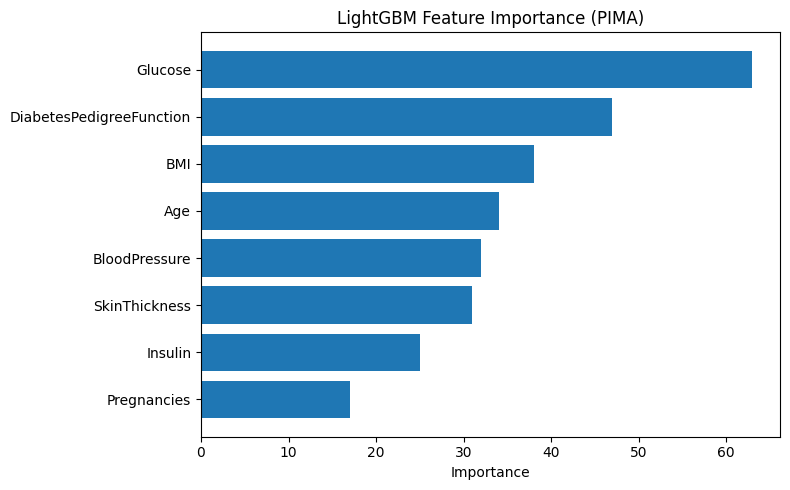

In [34]:
importances = final_model.feature_importances_
fi_df = pd.DataFrame(
    {"feature": FEATURE_COLS, "importance": importances}
).sort_values("importance", ascending=False)

print("\nFeature importances:")
print(fi_df)

plt.figure(figsize=(8, 5))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("LightGBM Feature Importance (PIMA)")
plt.tight_layout()
plt.show()

In [35]:
def predict_single_patient(model, sample_dict):
    """
    sample_dict: {"Pregnancies": 2, "Glucose": 120, ...}
    returns: probability of diabetes
    """
    x = pd.DataFrame([sample_dict], columns=FEATURE_COLS)
    # Make sure we also convert 0s to NaN for relevant columns
    x[cols_zero_as_missing] = x[cols_zero_as_missing].replace(0, np.nan)
    proba = model.predict_proba(x)[:, 1][0]
    return proba

# Example (fake patient, just to test the function)
example_patient = {
    "Pregnancies": 2,
    "Glucose": 130,
    "BloodPressure": 80,
    "SkinThickness": 20,
    "Insulin": 100,
    "BMI": 30.0,
    "DiabetesPedigreeFunction": 0.5,
    "Age": 35,
}

print("\nExample patient diabetes risk:",
      f"{predict_single_patient(final_model, example_patient)*100:.1f}%")


Example patient diabetes risk: 51.5%
